# 5.1 The Electric Field in a VTI Whole Space

Numerical examples of the book  

### Introduction to Controlled-Source Electromagnetic Methods  
Anton Ziolkowski and Evert Slob, 2019, *Cambridge University Press*; ISBN: [9781107058620](https://www.cambridge.org/9781107058620).

- - -
Copyright 2018 Dieter Werthmüller

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0). Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import numpy as np
import empymod as epm
import matplotlib.pyplot as plt

%matplotlib inline

### Choose your preferred colour map

The book shows in the chapter black-and-white figures, and in the plate section coloured versions.

In [2]:
plt.rcParams['image.cmap'] = 'viridis'  # Colour
# plt.rcParams['image.cmap'] = 'gray'   # Black-and-white

## Calculation

### Define total field functions

In [3]:
def total(freqtime, aniso, model):
    """Return total field of x-directed source; TE, TM, total."""
    
    # 1. Calculate x-, y-, and z-directed receiver fields
    resp1TE, resp1TM, _, _, _ = epm.analytical(ab=11, freqtime=freqtime,
                                               aniso=aniso, **model)
    resp2TE, resp2TM, _, _, _ = epm.analytical(ab=21, freqtime=freqtime,
                                               aniso=aniso, **model)
    resp3TE, resp3TM, _, _, _ = epm.analytical(ab=31, freqtime=freqtime,
                                               aniso=aniso, **model)

    # 2. Calculate total field for TE, TM, and TE+TM
    respTE = np.sqrt(np.abs(resp1TE)**2 + np.abs(resp2TE)**2 +
                     np.abs(resp3TE)**2)
    respTM = np.sqrt(np.abs(resp1TM)**2 + np.abs(resp2TM)**2 +
                     np.abs(resp3TM)**2)
    resp = np.sqrt(np.abs(resp1TE+resp1TM)**2 + np.abs(resp2TE+resp2TM)**2 +
                   np.abs(resp3TE+resp3TM)**2)
    return respTE, respTM, resp


def total_xy(freqtime, aniso, model, rx, ry):
    """Return total field of a fullspace in xy-plane; TE, TM, total."""
    
    model['rec'] = [rx.ravel(), ry.ravel(), 0]
    respTE, respTM, resp = total(freqtime, aniso, model)
    
    shp = rx.shape  # rx/ry-Original shape
    return respTE.reshape(shp), respTM.reshape(shp), resp.reshape(shp)


def total_xz(freqtime, aniso, model, rx, ry, x):
    """Return total field of a fullspace in xz-plane; TE, TM, total.
    
    Analytical solutions are only implemented for one depth at a time,
    so we have to loop over z.
    """

    # Define data type depending if frequency- or time-domain
    if model['signal']:
        dtype = float
    else:
        dtype = complex
    
    # Pre-allocate arrays
    respTE = np.zeros(rx.shape, dtype=dtype)
    respTM = np.zeros(rx.shape, dtype=dtype)
    resp = np.zeros(rx.shape, dtype=dtype)
    
    # Loop over z
    for i, val in enumerate(x):
        model['rec'] = [x, x*0, val]
        respTE[i, :], respTM[i, :], resp[i, :] = total(freqtime, aniso, model)

    return respTE, respTM, resp

### General model parameters

In [4]:
# Coordinates
x = np.linspace(-1e4, 1e4, 256)
rx = np.repeat([x, ], np.size(x), axis=0)
ry = rx.transpose()

# Common model parameters for analytical VTI solution
model = {'src': [0, 0, 0],     # Source location
         'res': 1,             # Resistivity
         'solution': 'dtetm',  # Diffusive full-space solution
         'verb': 1}            # Verbosity

### Calculate frequency-domain responses

In [5]:
# Frequency domain
model['signal'] = None

# 1.a isotropic xy-plane
respTE, respTM, resp = total_xy(1, 1, model, rx, ry)

# 1.b anisotropic xy-plane
respTEa, respTMa, respa = total_xy(1, 2, model, rx, ry)

# 2.a isotropic xz-plane
respvTE, respvTM, respv = total_xz(1, 1, model, rx, ry, x)

# 2.b anisotropic xz-plane
respvTEa, respvTMa, respva = total_xz(1, 2, model, rx, ry, x)

### Calculate time-domain responses

In [6]:
# Time domain; impulse response
model['signal'] = 0

# 1.a isotropic xy-plane
trespTE, trespTM, tresp = total_xy(0.5, 1, model, rx, ry)

# 1.b anisotropic xy-plane
trespTEa, trespTMa, trespa = total_xy(0.5, 2, model, rx, ry)

# 2.a isotropic xz-plane
trespvTE, trespvTM, trespv = total_xz(0.5, 1, model, rx, ry, x)

# 2.b anisotropic xz-plane
trespvTEa, trespvTMa, trespva = total_xz(0.5, 2, model, rx, ry, x)

### Plotting function

In [7]:
def plot_result(data, aniso, colorbar):
    """Create figure.
    
    All figures in this section are almost identical, just differ in
    the shown data. We can therefore define a plot-function which
    we subsequently call with the different results.
    
    """
    n = int(len(data)/2)
    
    # Define figure size, and title depending if 2 or 4 data-sets.
    if n == 2:
        E = [r'$\mathbf{E_H}$', r'$\mathbf{E_V}$']
        if colorbar:
            size = (10, 12.1)
        else:
            size = (10, 10.3)
    else:
        E = [r'$\mathbf{E}$', r'$\mathbf{E}$']
        if colorbar:
            size = (10, 5.3)
        else:
            size = (10, 4.45)
    
    # Addition to title and y-legend
    titadd =  [r'$\mathbf{z=z_s}$', r'$\mathbf{y=0}$ m']
    yaxadd = ['y', 'z']
    
    # Start figure
    fig, axs = plt.subplots(figsize=size, nrows=n, ncols=2)
    axs = axs.ravel()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # Loop over data
    for i, val in enumerate(data):
        plt.sca(axs[i])
        tit = r'$\mathbf{log_{10} |}$' + E[i // 2] + r'$|$ at ' + titadd[i % 2]
        plt.title(tit + ', $\mathbf{\lambda=}$' + str(aniso), fontweight='bold')

        dx = (x[1]-x[0])/2
        px = np.r_[x-dx, x[-1]+dx]/1000
        
        # Draw result
        cs = plt.pcolormesh(px, px, np.log10(np.abs(val)), vmin=-20, vmax=-8)

        # Draw contours at every decade
        cs2 = plt.contour(x/1000, x/1000, np.log10(np.abs(val)),
                          levels=np.arange(-20, -7),
                          linewidths=0.5, colors=[(0, 0, 0, 0.5)])

        plt.xticks([-10, -5, 0, 5, 10])
        plt.yticks([-10, -5, 0, 5, 10])
        plt.axis('equal')
        plt.xlabel('x-distance (km)')
        plt.ylabel(yaxadd[i % 2]+'-distance (km)')
        axs[i].invert_yaxis()

    # Plot colorbar
    if colorbar:
        cax, kw = plt.matplotlib.colorbar.make_axes(axs, location='bottom',
                                                    fraction=.05, pad=0.1, aspect=30)
        cb = plt.colorbar(cs, cax=cax, ticks=[-20, -15, -10], **kw)

    plt.show()

## Figure 5.1

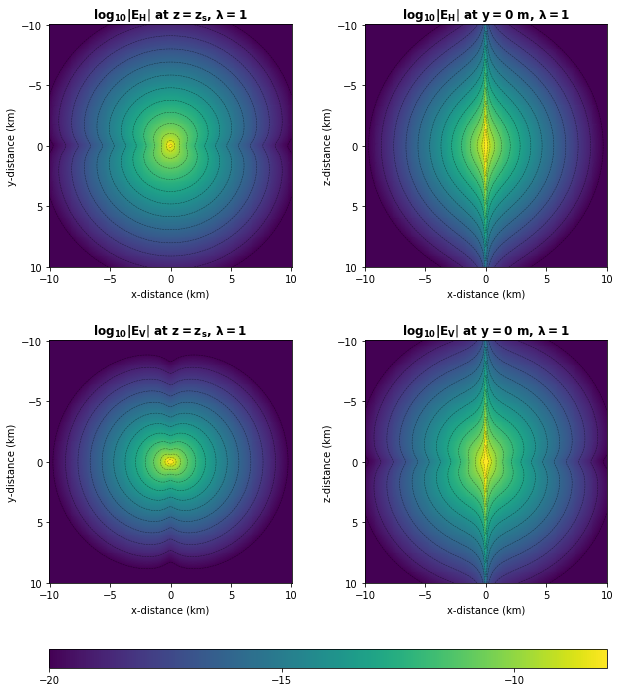

In [8]:
plot_result([respTE, respvTE, respTM, respvTM], 1, True)

Figure 5.1 The TE mode (top) and TM mode (bottom) electric field vector
magnitude in the ($x$, $y$)- (left) and the ($x$, $z$)-planes (right) for an $x$-directed electric current dipole operating at 1 Hz in an isotropic whole space.

## Figure 5.2

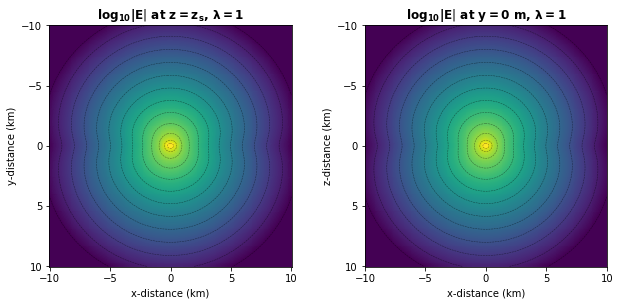

In [9]:
plot_result([resp, respv], 1, False)

Figure 5.2 The total electric field vector magnitude in the ($x$, $y$)-plane (left) and the ($x$, $z$)-plane (right) for an $x$-directed electric current dipole at 1 Hz in an isotropic whole space.

## Figure 5.3

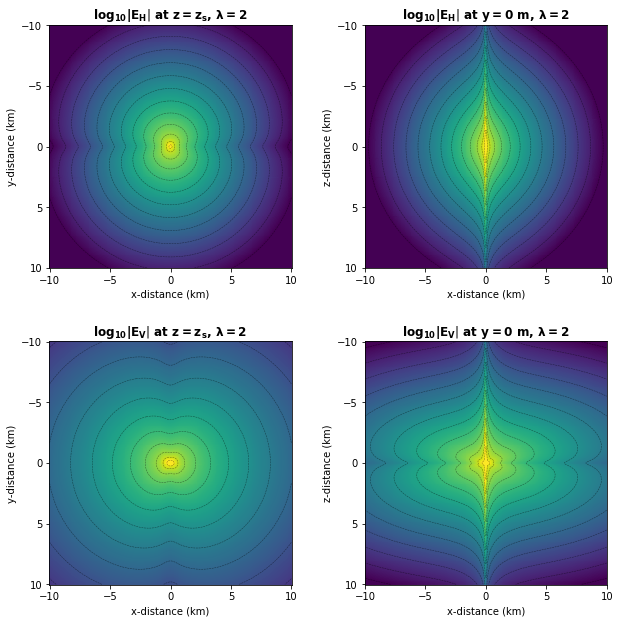

In [10]:
plot_result([respTEa, respvTEa, respTMa, respvTMa], 2, False)

Figure 5.3 The TE mode (left) and TM mode (right) electric field vector magnitude in the ($x$, $y$)-plane (top) and the ($x$, $z$)-plane (bottom) for an $x$-directed electric current dipole operating at 1 Hz in a VTI whole space with $\lambda$ = 2.

## Figure 5.4

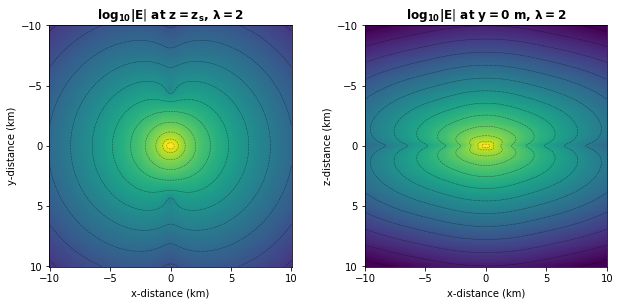

In [11]:
plot_result([respa, respva], 2, False)

Figure 5.4 The total electric field vector magnitude in the ($x$, $y$)-plane (left) and the ($x$, $z$)-plane (right) for an $x$-directed electric current dipole operating at 1 Hz in a VTI whole space with $\lambda$ = 2.

## Figure 5.5

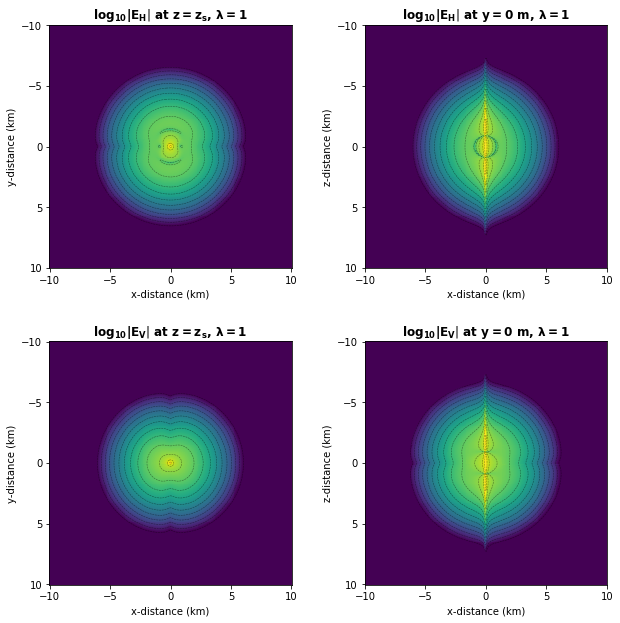

In [12]:
plot_result([trespTE, trespvTE, trespTM, trespvTM], 1, False)

Figure 5.5 The TE mode (top) and TM mode (bottom) electric field vector
magnitude at $t$ = 0.5 s in the ($x$, $y$)-plane (left) and the ($x$, $z$)-plane (right) for an $x$-directed electric current dipole in an isotropic whole space.

## Figure 5.6

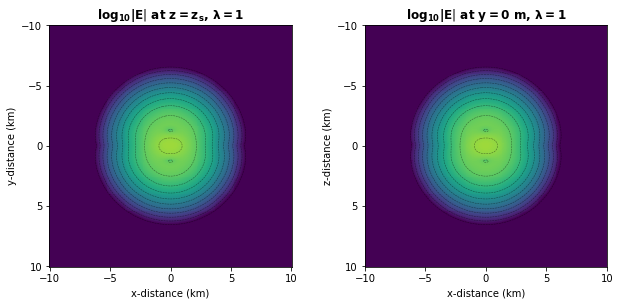

In [13]:
plot_result([tresp, trespv], 1, False)

Figure 5.6 The total electric field vector magnitude at $t$ = 0.5 s in the ($x$, $y$)-plane (left) and the ($x$, $z$)-plane (right) for an $x$-directed electric current dipole in an isotropic whole space.

## Figure 5.7

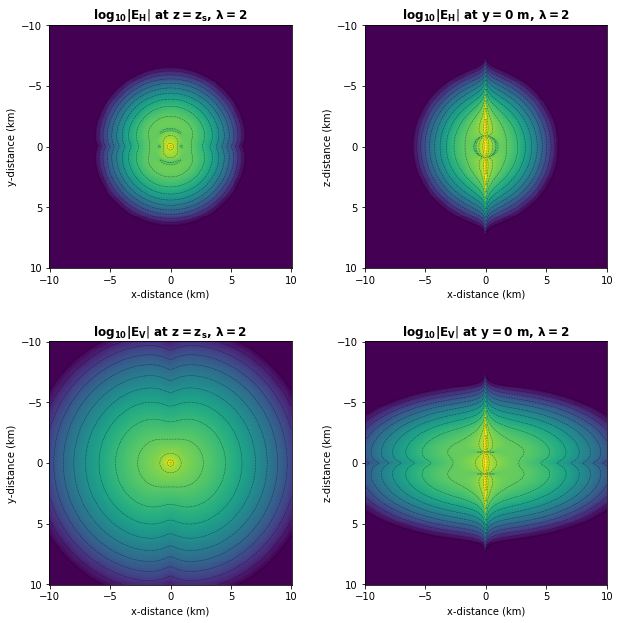

In [14]:
plot_result([trespTEa, trespvTEa, trespTMa, trespvTMa], 2, False)

Figure 5.7 The TE (left) and TM mode (right) electric field vector magnitude at $t$ = 0.5 s in the ($x$, $y$)-plane (top) and the ($x$, $z$)-plane (bottom) for an $x$-directed electric current dipole in a VTI whole space with $\lambda$ = 2.

## Figure 5.8

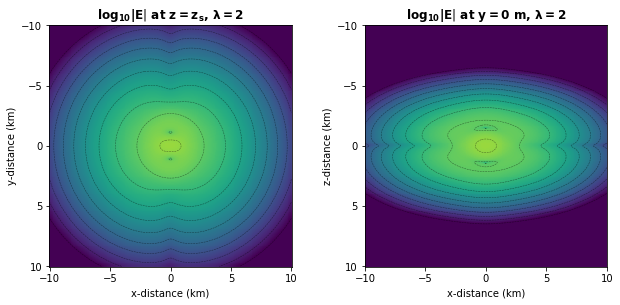

In [15]:
plot_result([trespa, trespva], 2, False)

Figure 5.8 The total electric field vector magnitude at $t$ = 0.5 s in the ($x$, $y$)-plane (left) and the ($x$, $z$)-plane (right) for an $x$-directed electric current dipole in a VTI whole space with $\lambda$ = 2.

In [16]:
epm.versions('HTML')